## Анализ маркетинговой стратегии компании

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) #Игнорирование предупреждения FutureWarning

In [29]:
bank = pd.read_csv('marketing_analysis_bank.csv', sep=';') 
bank.head()

cm = sns.light_palette("yellow", as_cmap=True) #Изменение дизайна таблицы
bank.head().style.background_gradient(cmap=cm) #Вывод таблицы

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.100000,93.994000,-36.400000,4.857000,5191.000000,no


In [30]:
bank.info() #Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
bank.isna().sum() #Пустые значения

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Анализ распределения числовых признаков

In [6]:
numerical_features = [col for col in bank.columns if np.issubdtype(bank[col].dtype, np.number)] #Возвращает True, если первый аргумент является кодом типа ниже/равно в иерархии типов
print(numerical_features) #Вывод числовых признаков

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [7]:
bank[numerical_features].describe().T #Свойство T является методом доступа к transpose().

cm = sns.light_palette("red", as_cmap=True) #Изменение дизайна таблицы
bank[numerical_features].describe().T.style.background_gradient(cmap=cm) #Вывод таблицы

,count,mean,std,min,25%,50%,75%,max
age,41188.000000,40.024060,10.421250,17.000000,32.000000,38.000000,47.000000,98.000000
duration,41188.000000,258.285010,259.279249,0.000000,102.000000,180.000000,319.000000,4918.000000
campaign,41188.000000,2.567593,2.770014,1.000000,1.000000,2.000000,3.000000,56.000000
pdays,41188.000000,962.475454,186.910907,0.000000,999.000000,999.000000,999.000000,999.000000
previous,41188.000000,0.172963,0.494901,0.000000,0.000000,0.000000,0.000000,7.000000
emp.var.rate,41188.000000,0.081886,1.570960,-3.400000,-1.800000,1.100000,1.400000,1.400000
cons.price.idx,41188.000000,93.575664,0.578840,92.201000,93.075000,93.749000,93.994000,94.767000
cons.conf.idx,41188.000000,-40.502600,4.628198,-50.800000,-42.700000,-41.800000,-36.400000,-26.900000
euribor3m,41188.000000,3.621291,1.734447,0.634000,1.344000,4.857000,4.961000,5.045000
nr.employed,41188.000000,5167.035911,72.251528,4963.600000,5099.100000,5191.000000,5228.100000,5228.100000


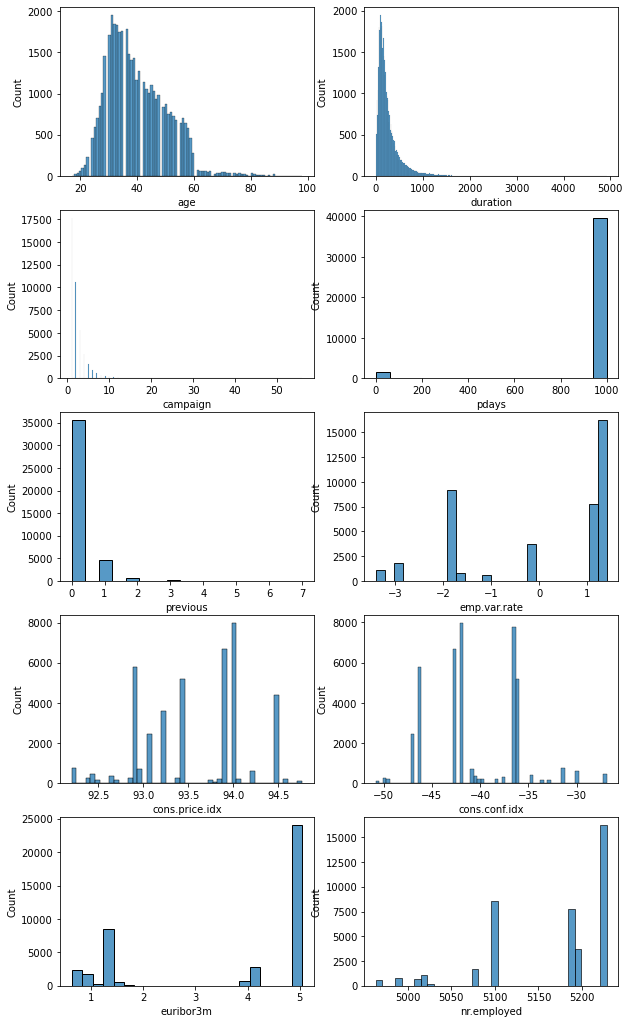

In [8]:
plt.figure(figsize=(10,18)) #Размер фигуры
for index, col in enumerate(numerical_features):
    plt.subplot(5, 2, index+1) #*args int, (int, int, index ) 
    sns.histplot(bank[col]) #Вывод графика числовых признаков

Анализ распределений категориальных признаков

In [9]:
categorical_features = [col for col in bank.columns if pd.api.types.is_string_dtype(bank[col])] #Возвращает True, если первый аргумент является кодом типа ниже/равно в иерархии типов
print(categorical_features) #Вывод категориальных признаков

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


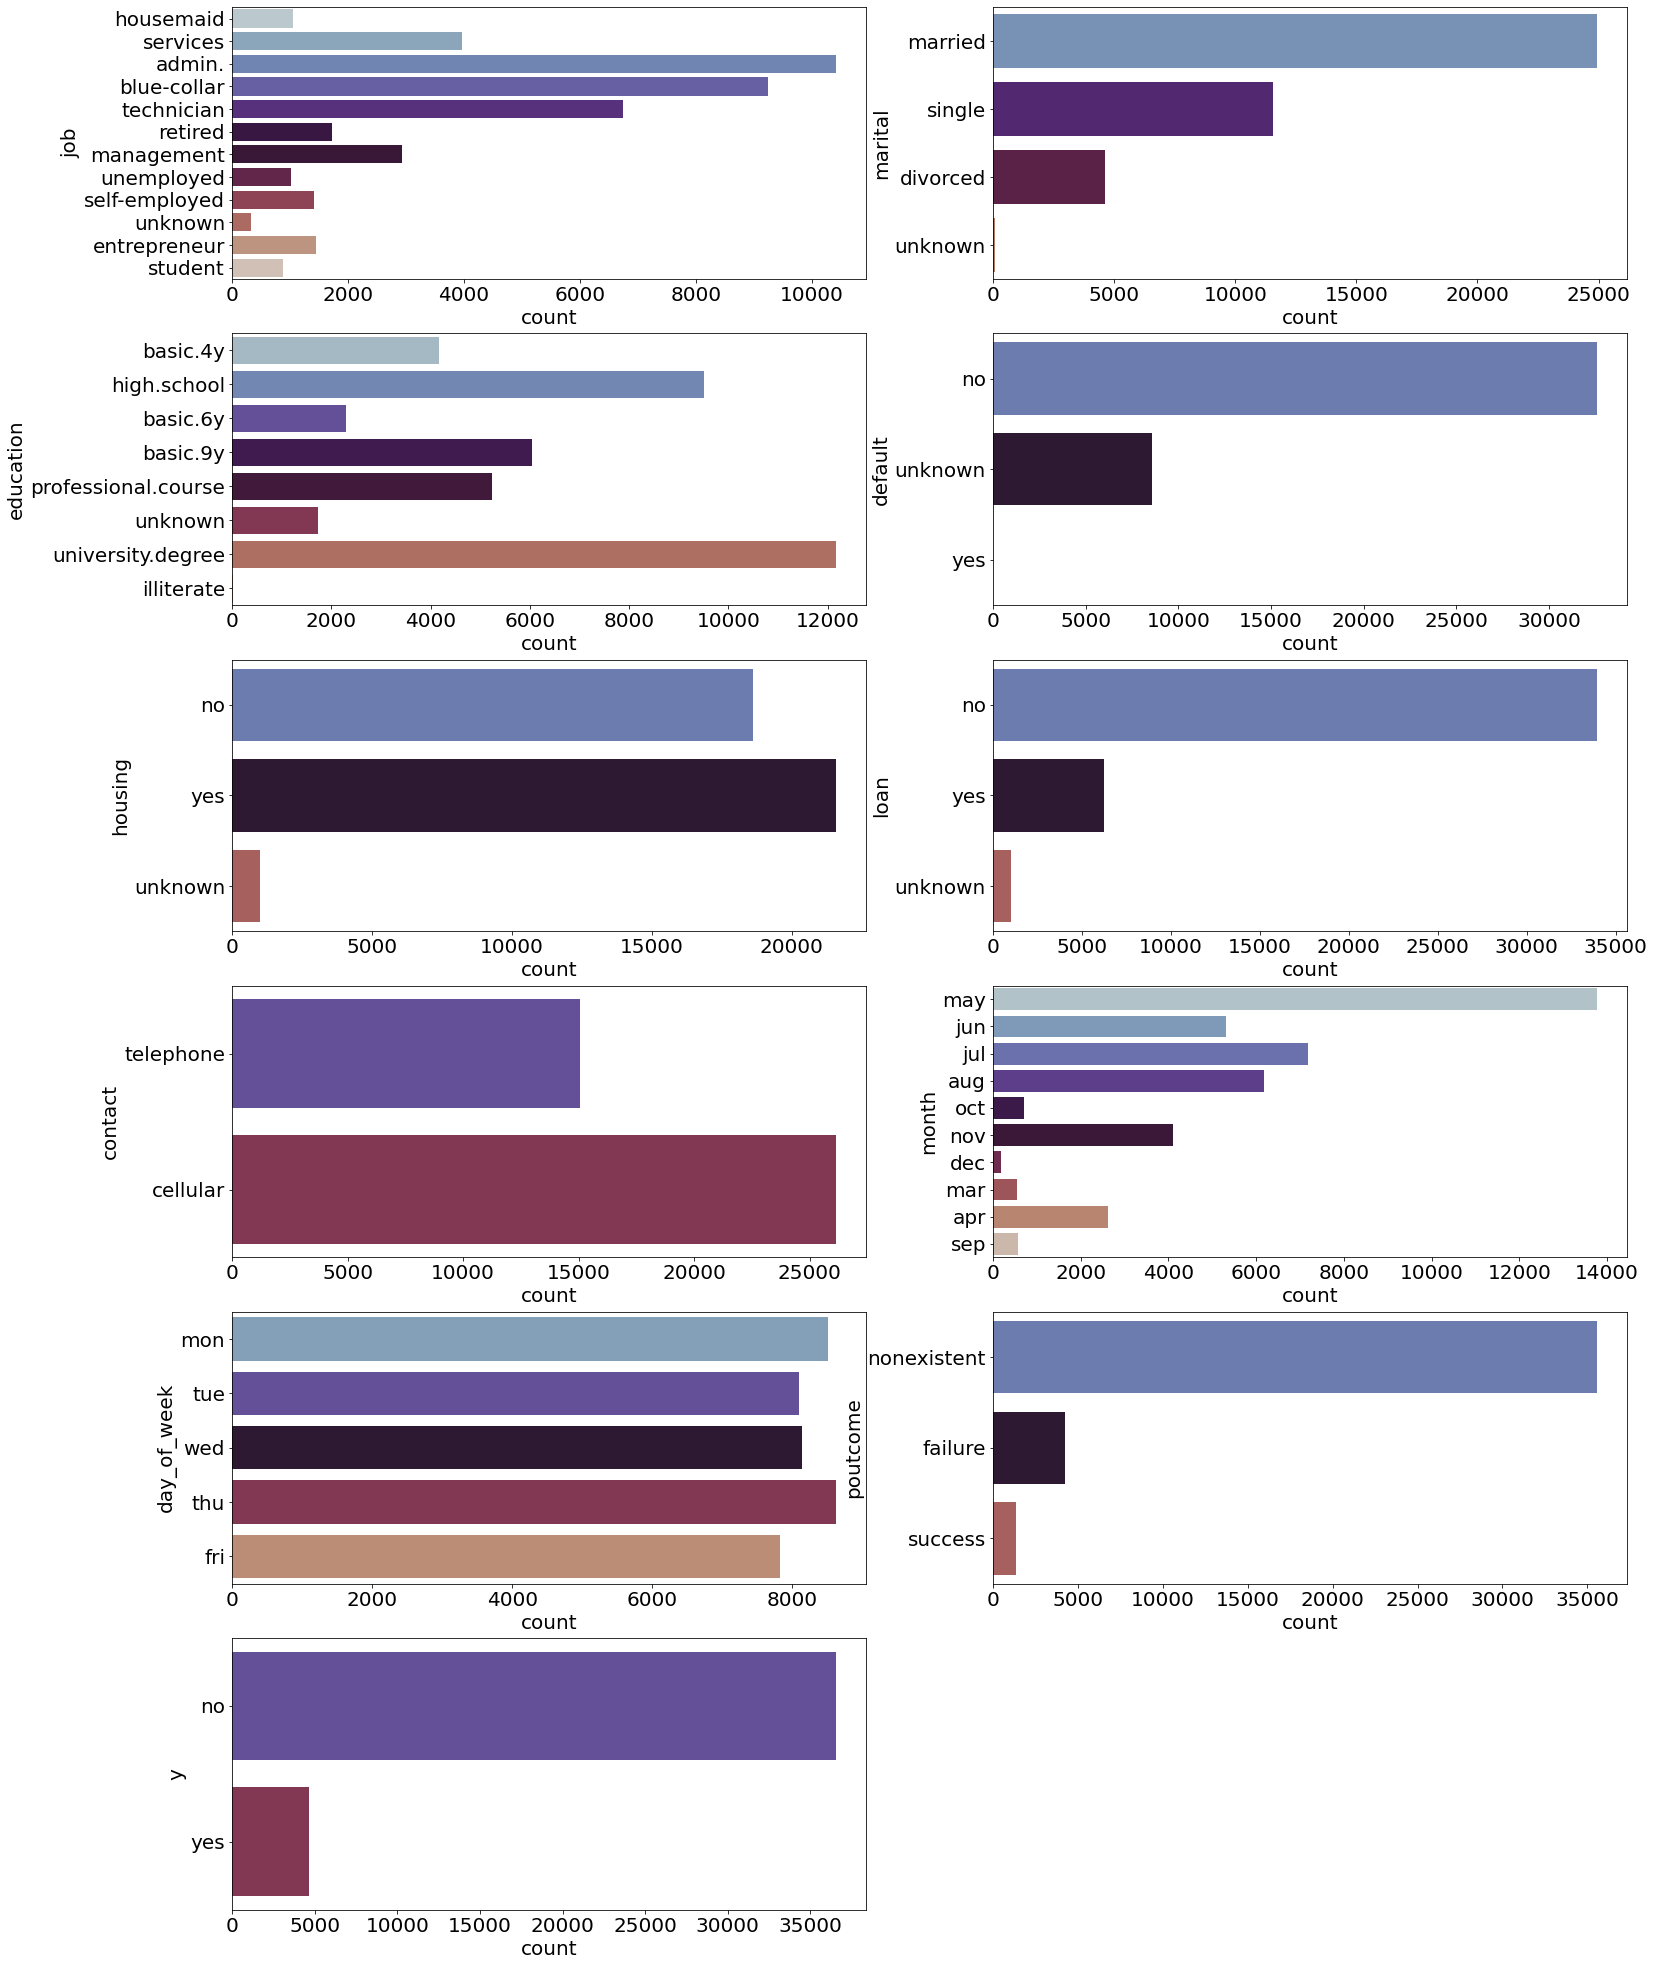

In [10]:
plt.figure(figsize=(25,35)) #Размер фигуры из библиотеки plt
for index, col in enumerate(categorical_features):
    plt.subplot(6, 2, index+1) #*args int, (int, int, index )
    ax = sns.countplot(y=col, data=bank, palette="twilight") #Выбор данных и палитры цветов
    ax.set_xlabel("count", fontsize=20) #Размеры лейблов
    ax.set_ylabel(col, fontsize=20)
    ax.tick_params(labelsize=20)

In [11]:
print("Total number of entries:") #Общее количество записей
print(bank["y"].value_counts(ascending=True)) #Количество значений по возрастанию
print()
print("Percentages:") #Проценты
print(bank["y"].value_counts(normalize=True,ascending=True)*100) #Количество значений и перевод в проценты

Total number of entries:
yes     4640
no     36548
Name: y, dtype: int64

Percentages:
yes    11.265417
no     88.734583
Name: y, dtype: float64


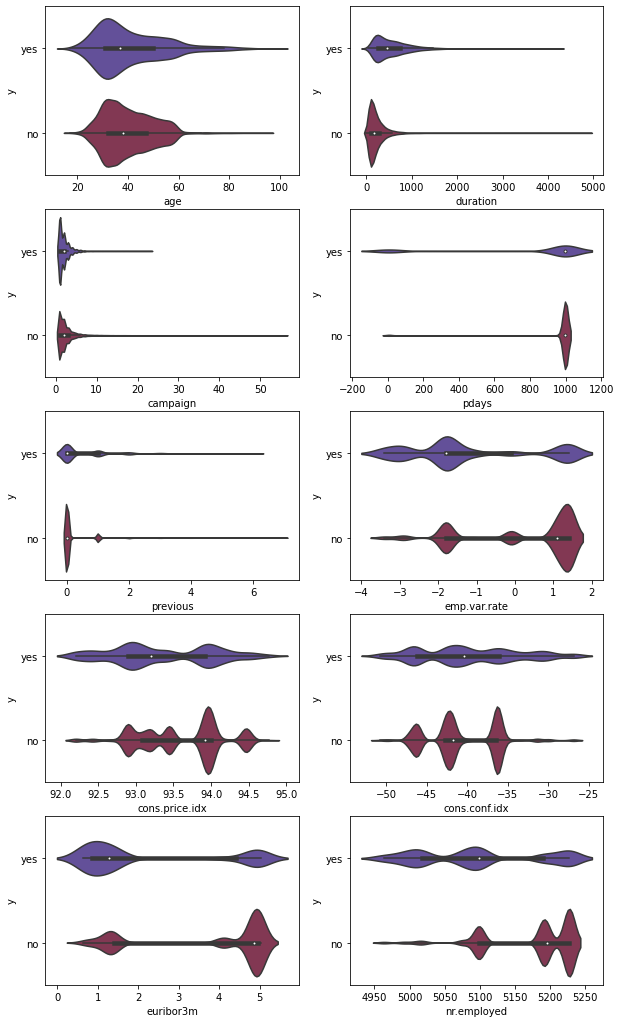

In [12]:
plt.figure(figsize=(10,18)) #Размер фигуры из библиотеки plt
for index, col in enumerate(numerical_features):
    plt.subplot(5, 2, index+1)
    sns.violinplot(x=col, y="y", data=bank,order=["yes", "no"], palette="twilight") #Выбор данных и палитры цветов

Влияние числовых характеристик на результат

In [13]:
from scipy.stats import ttest_ind #Вычисляет T-критерий для средних значений ДВУХ НЕЗАВИСИМЫХ выборок оценок

def test_means(data, col):
    yes_mask = data["y"] =="yes"
    values_yes = data[col][yes_mask]
    values_no = data[col][~yes_mask]
    mean_yes = values_yes.mean()
    mean_no = values_no.mean()
    
    ttest_res = ttest_ind(values_yes, values_no)
    
    return [col, mean_yes, mean_no, round(ttest_res[0], 4), round(ttest_res[1], 4)] #Округление

test_df = pd.DataFrame(columns=["column", "mean yes", "mean no", "ttest stat", "ttest pval"]) #Таблица

for index, col in enumerate(numerical_features):
    test_df.loc[index] = test_means(bank, col)
    
test_df

cm = sns.light_palette("purple", as_cmap=True) #Палитра
test_df.style.background_gradient(cmap=cm)

,column,mean yes,mean no,ttest stat,ttest pval
0,age,40.913147,39.911185,6.172100,0.000000
1,duration,553.191164,220.844807,89.967200,0.000000
2,campaign,2.051724,2.633085,-13.496500,0.000000
3,pdays,792.035560,984.113878,-69.722100,0.000000
4,previous,0.492672,0.132374,48.002700,0.000000
5,emp.var.rate,-1.233448,0.248875,-63.433700,0.000000
6,cons.price.idx,93.354386,93.603757,-27.903200,0.000000
7,cons.conf.idx,-39.789784,-40.593097,11.153900,0.000000
8,euribor3m,2.123135,3.811491,-65.646600,0.000000
9,nr.employed,5095.115991,5176.166600,-76.984500,0.000000


Проверка гипотезы о различии распределений числовых признаков

In [14]:
from scipy.stats import ks_2samp #( данные1 , данные2 , альтернатива = «двусторонний» , режим = «авто» ) 
#Сравнивает базовые непрерывные распределения F(x) и G(x) двух независимых выборок.
def test_ks(data, col):
    yes_mask = data["y"] == "yes"
    values_yes = data[col][yes_mask]
    values_no = data[col][~yes_mask]
    
    kstest_res = ks_2samp(values_yes, values_no) #Функция для вычисления p-значения теста KS, дополнительно выполняющая коррекцию на эффективный размер выборки.
    return [col, round(kstest_res[0], 4), round(kstest_res[1], 4)] #Округление

test_df = pd.DataFrame(columns=["column", "ks stat", "ks pval"]) #Таблица

for index, col in enumerate(numerical_features):
    test_df.loc[index] = test_ks(bank, col)
    
test_df
cm = sns.light_palette("pink", as_cmap=True) #Палитра
test_df.style.background_gradient(cmap=cm)

,column,ks stat,ks pval
0,age,0.086100,0.000000
1,duration,0.464100,0.000000
2,campaign,0.080800,0.000000
3,pdays,0.193400,0.000000
4,previous,0.210200,0.000000
5,emp.var.rate,0.432400,0.000000
6,cons.price.idx,0.228100,0.000000
7,cons.conf.idx,0.199800,0.000000
8,euribor3m,0.432600,0.000000
9,nr.employed,0.432400,0.000000


Создание массивов, содержащих кампании и финансовые столбцы

In [15]:
campaign_columns = ["age", "duration", "campaign", "previous"]
financial_columns = ["emp.var.rate", "cons.price.idx", \
                     "cons.conf.idx", "euribor3m"]

<Figure size 720x720 with 0 Axes>

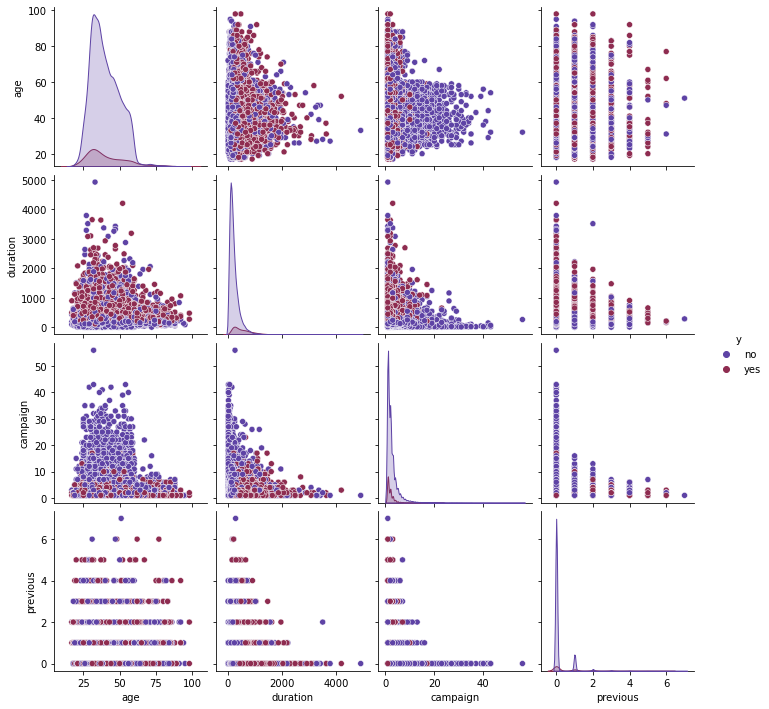

In [16]:
#создание парного графика между столбцами кампании
plot_data = bank[campaign_columns + ["y"]] #Данные
plt.figure(figsize=(10,10)) #Размер
sns.pairplot(plot_data, hue="y", palette="twilight") #Палитра

<Figure size 720x720 with 0 Axes>

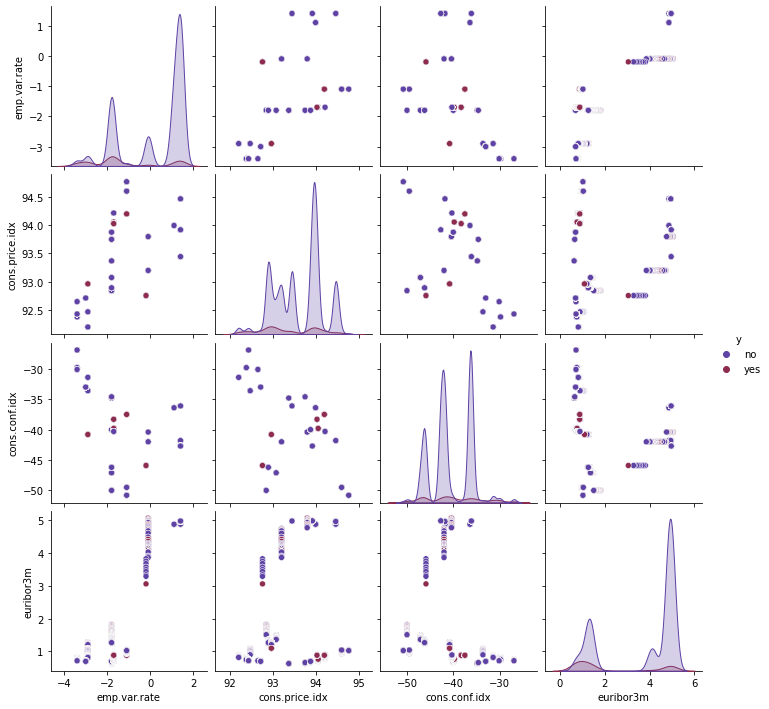

In [17]:
#создание парного графика между финансовыми функциями
plot_data = bank[financial_columns + ["y"]] #Данные
plt.figure(figsize=(10,10)) #Размер
sns.pairplot(plot_data, hue="y", palette="twilight") #Палитра

Анализ корреляции между различными числовыми характеристиками

In [18]:
successful_calls = bank.y == "yes"

#построение матрицы корреляции для успешных вызовов
plot_data = bank[campaign_columns + financial_columns][successful_calls] #Наносит на график данные, подобранные значения или остатки
successful_corr = plot_data.corr() #Успешная корреляция -> Матрица
successful_corr.style.background_gradient(cmap='twilight').set_precision(2) #Палитра

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m
age,1.00,-0.06,-0.01,0.07,-0.08,-0.02,0.14,-0.09
duration,-0.06,1.00,0.16,-0.23,0.50,0.24,-0.14,0.50
campaign,-0.01,0.16,1.00,-0.10,0.22,0.12,-0.04,0.21
previous,0.07,-0.23,-0.10,1.00,-0.28,0.09,0.13,-0.39
emp.var.rate,-0.08,0.50,0.22,-0.28,1.00,0.66,-0.27,0.93
cons.price.idx,-0.02,0.24,0.12,0.09,0.66,1.00,-0.33,0.41
cons.conf.idx,0.14,-0.14,-0.04,0.13,-0.27,-0.33,1.00,-0.12
euribor3m,-0.09,0.50,0.21,-0.39,0.93,0.41,-0.12,1.00


In [19]:
#построение матрицы корреляции для неудачных вызовов
plot_data = bank[campaign_columns + financial_columns][~successful_calls] #Данные
unsuccessful_corr = plot_data.corr() #Неудачная корреляция -> Матрица
unsuccessful_corr.style.background_gradient(cmap='twilight').set_precision(2) #Палитра

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m
age,1.00,0.00,0.01,-0.00,0.03,0.01,0.12,0.04
duration,0.00,1.00,-0.08,-0.00,0.00,0.02,0.00,0.01
campaign,0.01,-0.08,1.00,-0.07,0.13,0.12,-0.01,0.12
previous,-0.00,-0.00,-0.07,1.00,-0.42,-0.27,-0.14,-0.44
emp.var.rate,0.03,0.00,0.13,-0.42,1.00,0.80,0.32,0.98
cons.price.idx,0.01,0.02,0.12,-0.27,0.80,1.00,0.15,0.73
cons.conf.idx,0.12,0.00,-0.01,-0.14,0.32,0.15,1.00,0.39
euribor3m,0.04,0.01,0.12,-0.44,0.98,0.73,0.39,1.00


In [20]:
    #разница в графике успешных и неудачных матриц корреляции

diff_corr = successful_corr - unsuccessful_corr #Функция разницы
diff_corr.style.background_gradient(cmap='twilight').set_precision(2) #Палитра

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m
age,0.00,-0.06,-0.02,0.08,-0.11,-0.04,0.02,-0.13
duration,-0.06,0.00,0.24,-0.23,0.50,0.22,-0.15,0.49
campaign,-0.02,0.24,0.00,-0.04,0.09,-0.01,-0.04,0.10
previous,0.08,-0.23,-0.04,0.00,0.14,0.36,0.27,0.05
emp.var.rate,-0.11,0.50,0.09,0.14,0.00,-0.14,-0.59,-0.05
cons.price.idx,-0.04,0.22,-0.01,0.36,-0.14,0.00,-0.48,-0.32
cons.conf.idx,0.02,-0.15,-0.04,0.27,-0.59,-0.48,0.00,-0.51
euribor3m,-0.13,0.49,0.10,0.05,-0.05,-0.32,-0.51,0.00


Линейная регрессия

In [21]:
import statsmodels.api as sm #Импорт модели из statsmodel

X = bank[["emp.var.rate", "cons.price.idx", "euribor3m"]] #Переменные
X = sm.add_constant(X)
y = bank["cons.conf.idx"]

linear_regression_model = sm.OLS(y, X) #функция наименьших квадратов
result = linear_regression_model.fit()
print(result.summary()) #Выводим в формате резюме

                            OLS Regression Results                            
Dep. Variable:          cons.conf.idx   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     2960.
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:02:04   Log-Likelihood:            -1.1753e+05
No. Observations:               41188   AIC:                         2.351e+05
Df Residuals:                   41184   BIC:                         2.351e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -82.4025      5.999    -13.

Логистическая регрессия

In [22]:
X = bank[["age", "duration", "campaign", "previous"]] #Переменные
X = sm.add_constant(X)
y = np.where(bank["y"] == "yes", 1, 0)

logistic_regression_model = sm.Logit(y, X) #логистическая регрессия
result = logistic_regression_model.fit()
print(result.summary()) #Выводим в формате резюме

Optimization terminated successfully.
         Current function value: 0.269969
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41183
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Jun 2022   Pseudo R-squ.:                  0.2331
Time:                        21:02:04   Log-Likelihood:                -11119.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7793      0.076    -49.435      0.000      -3.929      -3.629
age            0.0091      0.

Логистическая регрессия на полных данных маркетинговой кампании

In [23]:
#преобразование всех признаков в числовые значения

X = bank.drop("y", axis=1)
X = pd.get_dummies(X)
X = sm.add_constant(X)
print(X.columns)

Index(['const', 'age', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 

In [24]:
y = np.where(bank["y"] == "yes", 1 ,0) #выбор элементов из массива numpy с условием
full_logistic_regression_model = sm.Logit(y, X) #Назначение переменной
result = full_logistic_regression_model.fit(maxiter=500) #логистичекая регрессия на полных данных с макс 500
print(result.summary()) #Выводим в формате резюме

Optimization terminated successfully.
         Current function value: 0.207316
         Iterations 113
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41135
Method:                           MLE   Df Model:                           52
Date:                Mon, 20 Jun 2022   Pseudo R-squ.:                  0.4111
Time:                        21:02:08   Log-Likelihood:                -8538.9
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -83.1000    8.9e+05  -9.34e-05      

Создание более экономичной модели логистической регрессии

In [25]:
import statsmodels.api as sm #Импорт

columns = ["duration", "campaign", "pdays", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m"] #Выбор данных
X = bank[columns]
X = sm.add_constant(X)
X.head()

cm = sns.light_palette("blue", as_cmap=True) #Палитра
X.head().style.background_gradient(cmap=cm) #Вывод

,const,duration,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m
0,1.000000,261,1,999,1.100000,93.994000,-36.400000,4.857000
1,1.000000,149,1,999,1.100000,93.994000,-36.400000,4.857000
2,1.000000,226,1,999,1.100000,93.994000,-36.400000,4.857000
3,1.000000,151,1,999,1.100000,93.994000,-36.400000,4.857000
4,1.000000,307,1,999,1.100000,93.994000,-36.400000,4.857000


In [26]:
y = np.where(bank["y"] == "yes", 1, 0) #выбор элементов из массива numpy с условием
logistic_regression_model = sm.Logit(y, X) #Назначение переменной
result = logistic_regression_model.fit() #логистическая регрессия
print(result.summary()) #Вывод в формате резюме

Optimization terminated successfully.
         Current function value: 0.220751
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41180
Method:                           MLE   Df Model:                            7
Date:                Mon, 20 Jun 2022   Pseudo R-squ.:                  0.3729
Time:                        21:02:08   Log-Likelihood:                -9092.3
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -90.4650      5.683    -15.919      0.000    -101.603     -79.327
duration         